49344.330991020135
0.0
[0.0023623  0.00223505 0.0021222  0.00207724 0.00200462 0.0019776
 0.00196217 0.00194934 0.00194886 0.00190763 0.00189787 0.00189547
 0.00187867 0.00191461 0.00191517 0.00193449 0.00194244 0.00195944
 0.00199279 0.00200874 0.00202055 0.00199476 0.00197436 0.00196682
 0.00196065 0.00196194 0.00196737 0.00200201 0.00201582 0.00199547
 0.00201101 0.00195778 0.00192996 0.00191712 0.00188682 0.00187473
 0.00188231 0.0018886  0.00187917 0.00189087 0.00189033 0.00190113
 0.0019144  0.00188282 0.00189082 0.00192809 0.00195532 0.00199013
 0.00196404 0.001999   0.00202139 0.00207897 0.00206165 0.00211527
 0.00213554 0.00226945 0.00212292 0.0020463  0.002009   0.00200201
 0.00194517 0.00195969 0.00192859 0.0019473  0.0019681  0.00196862
 0.00196048 0.00196565 0.00196102 0.00194304 0.00194256 0.00193497
 0.00194999 0.0019508  0.00196934 0.00200567 0.00202181 0.0020345
 0.00202352 0.00200762 0.00200625 0.00202351 0.00202193 0.00200953
 0.00198001 0.00200207 0.00199996 0.00204

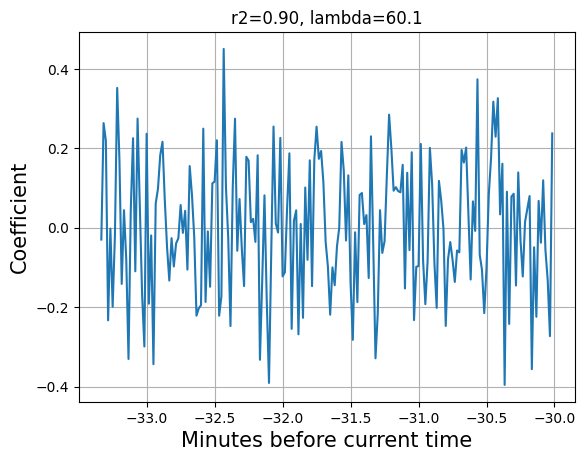

In [1]:
"""
Use ridge regression to predict X-ray flux at a given time
distance into the future, using a block of consecutive values.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats.distributions import chi2
from read import *

# Regress y on x using ridge regression, with penalty parameter f.
def ridge(x, y, f):
    u, s, vt = np.linalg.svd(x, 0)
    v = vt.T
    g = s / (s**2 + f)
    b = np.dot(v, np.dot(u.T, y) * g)
    return b

# Ridge regression with tuning based on a hyperpenaized log likelihood.
# Requires a guess of the R^2 (r2).
#
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4790465/
def tuneridge(x, y, r2):
    n, p = x.shape
    # The hyperpenalty parameters
    a = p / 2
    b = 1 / np.sqrt(1/r2 - 1)

    # Estimate the parameters for fixed penalty value using ridge regression.
    u, s, vt = np.linalg.svd(x, 0)
    v = vt.T
    def fit(lam):
        g = s / (s**2 + lam)
        return np.dot(v, np.dot(u.T, y) * g)

    lam = 1.
    bhat = fit(lam)
    for itr in range(100):
        resid = y - np.dot(x, bhat)
        rss = np.sum(resid**2)
        bss = np.sum(bhat**2)
        sigma2 = (rss + lam*bss) / (n + p + 2)
        lam = (p + 2*a - 2) / (bss/sigma2 + 2*b)
        bhat1 = fit(lam)
        if np.sum((bhat1 - bhat)**2) < 1e-4:
            break
        bhat = bhat1

    return bhat, lam, sigma2

def test_tuneridge():
    n = 2000
    p = 20
    r = 0.5
    sig = 2
    x = np.random.normal(size=(n, p))
    for j in range(1, p):
        x[:, j] = r*x[:, j-1] + np.sqrt(1-r**2)*x[:, j]
    b = np.zeros(p)
    b[0] = 1
    Ey = np.dot(x, b)
    y = Ey + sig*np.random.normal(size=n)

    r2 = np.var(Ey) / (np.var(Ey) + sig**2)
    ii = np.arange(p)
    covx = r**np.abs(np.subtract.outer(ii, ii))

    # The large sample optimal lambda
    lam_opt = sig**2 * np.trace(np.linalg.inv(covx)) / np.dot(b, np.linalg.solve(covx, b))

    bhat, lam, sigma2 = tuneridge(x, y, r2)
    return lam, lam_opt, r2

pdf = PdfPages("autoreg_py.pdf")

df = get_goes(2017)

# Use blocks of size m, and use the first q observations within
# each block to predict the final observation in the block.
m = 1000
q = 200

# The time points of the predictor information relative to the time
# being predicted.
tax = np.arange(-2*m, -2*(m-q))[0:q] / 60

# Make blocks of 'm' consecutive time points with
# approximately 2-second spacing.
tix, flx = make_blocks(df, m, 0)

flx = np.log(1e-8 + flx)

# Create a design matrix and response vector
x = flx[:, 0:q]
y = flx[:, -1]

# Center the data
y -= y.mean()
x -= x.mean(0)

xtx = np.dot(x.T, x)

# Consider how the regression coefficients look for various values
# of the penalty parameter.
def fit(x, y, randomize):

    if randomize:
        y = 3 * np.random.normal(size=len(y))

    for r2 in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]:
        b, lam, s2 = tuneridge(x, y, r2)

        H = xtx + lam*np.eye(q)
        V = s2 * np.linalg.solve(H, np.linalg.solve(H, xtx).T)
        cs = np.dot(b, np.linalg.solve(V, b))
        pv = 1 - chi2(len(b)).cdf(cs)
        print(cs)
        print(pv)
        print(np.sqrt(np.diag(V)))

        plt.clf()
        plt.grid(True)
        plt.plot(tax, b, "-")
        plt.ylabel("Coefficient", size=15)
        plt.xlabel("Minutes before current time", size=15)
        plt.title("r2=%.2f, lambda=%.1f" % (r2, lam))
        pdf.savefig()

fit(x, y, False)
fit(x, y, True)

pdf.close()